In [2]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.tokenize import word_tokenize
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import nltk

In [3]:
path = 'train_sent_emo.csv'
train = pd.read_csv(path)
path = 'test_sent_emo.csv'
test = pd.read_csv(path)
path = 'dev_sent_emo_replaced.csv'
dev = pd.read_csv(path)

In [4]:
train.replace({"positive":1,"negative":-1, "neutral":0, "anger":1, "surprise":6, "disgust":2, "fear":3, "joy":4, "sadness":5  },inplace=True)
train.drop(columns=['Sr No.', 'Speaker', 'Dialogue_ID', 'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'], axis=1, inplace=True)
train.head()

,Utterance,Emotion,Sentiment
0,also I was the point person on my companys tr...,0,0
1,You mustve had your hands full.,0,0
2,That I did. That I did.,0,0
3,So lets talk a little bit about your duties.,0,0
4,My duties? All right.,6,1


In [6]:
def normalise_text(text):
    text = text.lower()  # lowercase
    text = text.replace(r"\#", "")  # replaces hashtags
    text = text.replace(r"http\S+", "URL")  # remove URL addresses
    text = text.replace(r"@", "")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

In [7]:
train.Utterance = train.Utterance.apply(normalise_text)
test.Utterance = test.Utterance.apply(normalise_text)

In [8]:
test_s = test.copy()
test_s.replace({"positive":1,"negative":-1, "neutral":0, "anger":1, "surprise":6, "disgust":2, "fear":3, "joy":4, "sadness":5  },inplace=True)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             ngram_range=(1,3)) # number of n-grams

bow_data = bow_counts.fit_transform(train['Utterance'])

In [11]:
labels = train['Emotion']

In [12]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=10000),
    CatBoostClassifier(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, bow_data, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

KeyboardInterrupt: 

In [92]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.593151,0.016115
LinearSVC,0.578236,0.003508
LogisticRegression,0.602262,0.008263
MultinomialNB,0.572629,0.008374
RandomForestClassifier,0.471519,0.000106


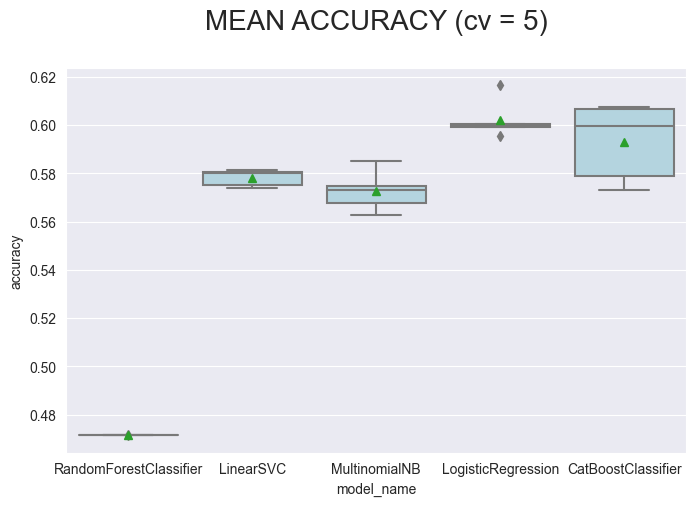

In [93]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

In [24]:
bow_test = bow_counts.transform(test['Utterance'])

In [14]:
test.replace({"positive":1,"negative":-1, "neutral":0, "anger":1, "surprise":6, "disgust":2, "fear":3, "joy":4, "sadness":5  },inplace=True)

In [14]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.3, random_state=42, max_iter=10000, verbose=1, n_jobs=3).fit(bow_data, labels)
y_pred= clf.predict(bow_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


convergence after 1281 epochs took 1816 seconds


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed: 30.3min finished


In [33]:
y_test = test.Emotion.copy()

In [16]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.68      0.88      0.77      1256
           1       0.48      0.28      0.35       345
           2       0.44      0.06      0.10        68
           3       0.14      0.02      0.04        50
           4       0.46      0.50      0.48       402
           5       0.37      0.14      0.20       208
           6       0.56      0.52      0.54       281

    accuracy                           0.61      2610
   macro avg       0.45      0.34      0.35      2610
weighted avg       0.57      0.61      0.57      2610



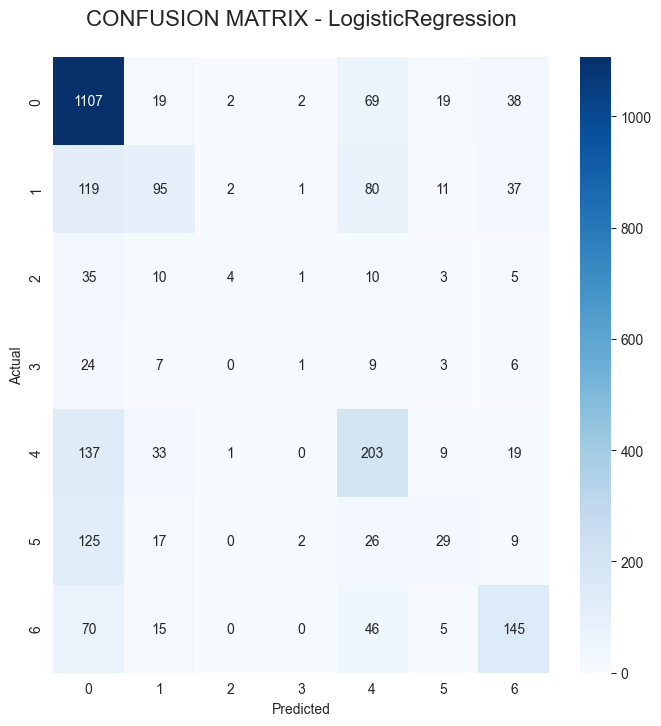

In [17]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')#,
            # xticklabels=pd.DataFrame(train1['Emotion'].unique()).values,
            # yticklabels=pd.DataFrame(train1['Emotion'].unique()).values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

In [21]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.1, random_state=42, max_iter=10000, verbose=1, n_jobs=3).fit(bow_data, labels)
y_pred= clf.predict(bow_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


convergence after 1427 epochs took 4430 seconds


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed: 73.8min finished


In [22]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.68      0.89      0.77      1256
           1       0.48      0.26      0.34       345
           2       0.50      0.06      0.11        68
           3       0.14      0.02      0.04        50
           4       0.48      0.53      0.50       402
           5       0.39      0.12      0.19       208
           6       0.55      0.51      0.53       281

    accuracy                           0.61      2610
   macro avg       0.46      0.34      0.35      2610
weighted avg       0.57      0.61      0.57      2610



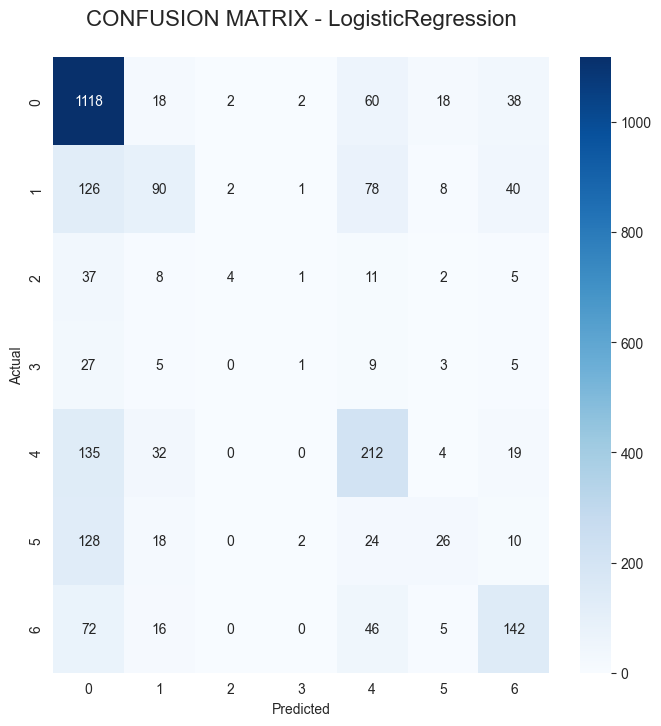

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

Добавляем Sentiment

In [24]:
labels = train['Sentiment']

In [25]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=10000),
    CatBoostClassifier(),
    #LGBMClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, bow_data, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Learning rate set to 0.087974
0:	learn: 1.0697116	total: 401ms	remaining: 6m 40s
1:	learn: 1.0461566	total: 644ms	remaining: 5m 21s
2:	learn: 1.0267758	total: 874ms	remaining: 4m 50s
3:	learn: 1.0107049	total: 1.12s	remaining: 4m 39s
4:	learn: 0.9972273	total: 1.39s	remaining: 4m 36s
5:	learn: 0.9859294	total: 1.72s	remaining: 4m 44s
6:	learn: 0.9765350	total: 1.94s	remaining: 4m 35s
7:	learn: 0.9685949	total: 2.18s	remaining: 4m 30s
8:	learn: 0.9610401	total: 2.44s	remaining: 4m 28s
9:	learn: 0.9554617	total: 2.68s	remaining: 4m 25s
10:	learn: 0.9504612	total: 2.92s	remaining: 4m 22s
11:	learn: 0.9451098	total: 3.15s	remaining: 4m 19s
12:	learn: 0.9408026	total: 3.38s	remaining: 4m 16s
13:	learn: 0.9361855	total: 3.6s	remaining: 4m 13s
14:	learn: 0.9318609	total: 3.83s	remaining: 4m 11s
15:	learn: 0.9273194	total: 4.05s	remaining: 4m 9s
16:	learn: 0.9252039	total: 4.28s	remaining: 4m 7s
17:	learn: 0.9231512	total: 4.51s	remaining: 4m 6s
18:	learn: 0.9201429	total: 4.74s	remaining: 4m 

In [26]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1,
                ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.645809,0.017715
LinearSVC,0.629191,0.007365
LogisticRegression,0.645608,0.010592
MultinomialNB,0.616476,0.014764
RandomForestClassifier,0.471519,0.000106


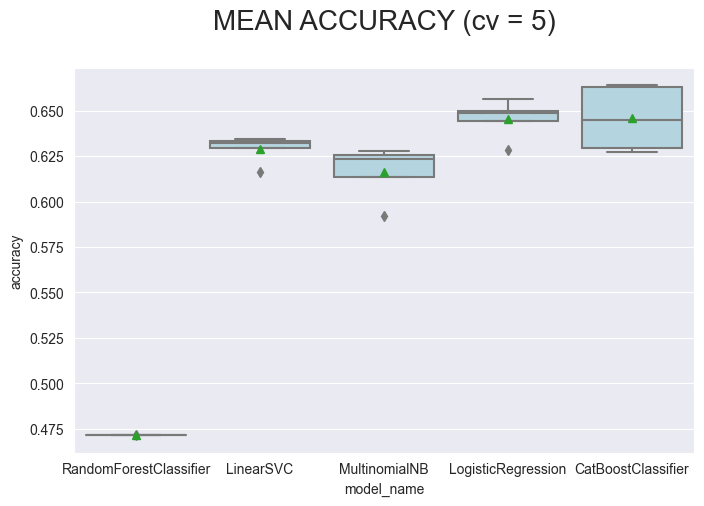

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

0       0
1       0
2       0
3       0
4       1
       ..
9984    0
9985    0
9986    1
9987    0
9988    1
Name: Sentiment, Length: 9989, dtype: int64

In [26]:
labels_s = train.Sentiment.copy()

## Предсказываем сантимент по тексту

In [28]:
sent_clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.1, random_state=42, max_iter=10000, verbose=1,
                         n_jobs=4).fit(bow_data, labels_s)
y_pred_s = sent_clf.predict(bow_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 1143 epochs took 3198 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 53.3min finished


In [29]:
y_test_s = test_s.Sentiment.copy()

In [31]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test_s, y_pred_s))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

          -1       0.64      0.47      0.54       833
           0       0.70      0.85      0.77      1256
           1       0.56      0.52      0.54       521

    accuracy                           0.66      2610
   macro avg       0.63      0.61      0.62      2610
weighted avg       0.65      0.66      0.65      2610



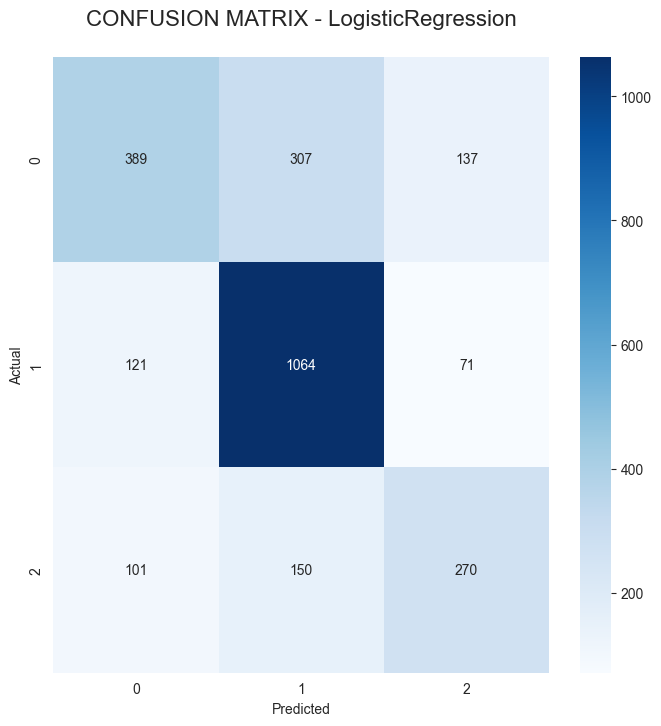

In [32]:
conf_mat = confusion_matrix(y_test_s, y_pred_s)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')#,
            # xticklabels=pd.DataFrame(train1['Emotion'].unique()).values,
            # yticklabels=pd.DataFrame(train1['Emotion'].unique()).values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

Добавим тональные векторы

In [16]:
test_vecs = pd.read_csv('test_sentivecs.csv')
train_vecs = pd.read_csv('train_sentivecs.csv')

In [17]:
bow_data

<9989x100538 sparse matrix of type '<class 'numpy.int64'>'
	with 266551 stored elements in Compressed Sparse Row format>

In [20]:
from scipy.sparse import coo_matrix, hstack
X_train = bow_data
sent = train_vecs
#X_utt_sen = hstack([X_train, sent])
X_utt_sen = bow_data
for each in train_vecs.columns:
    print(each)
    bow_data = scipy.sparse.csr_matrix(bow_data)
    bow_data = hstack((bow_data,np.array(train_vecs[each])[:,None])).A

max_pos
mean_pos
max_neg
mean_neg
num_neut
num_pos
num_neg


In [ ]:
bow_data

In [21]:
bow_data = scipy.sparse.csr_matrix(bow_data)
bow_data

<9989x100545 sparse matrix of type '<class 'numpy.float64'>'
	with 302816 stored elements in Compressed Sparse Row format>

In [25]:
X_test = bow_test
sent = test_vecs
for each in test_vecs.columns:
    print(each)
    bow_test = scipy.sparse.csr_matrix(bow_test)
    bow_test = hstack((bow_test,np.array(test_vecs[each])[:,None])).A

max_pos
mean_pos
max_neg
mean_neg
num_neut
num_pos
num_neg


In [26]:
bow_test = scipy.sparse.csr_matrix(bow_test)
bow_test

<2610x100545 sparse matrix of type '<class 'numpy.float64'>'
	with 59086 stored elements in Compressed Sparse Row format>

In [27]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=10000),
    CatBoostClassifier(),
    #LGBMClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, bow_data, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Learning rate set to 0.087974
0:	learn: 1.8151520	total: 485ms	remaining: 8m 4s
1:	learn: 1.7289999	total: 843ms	remaining: 7m
2:	learn: 1.6657652	total: 1.23s	remaining: 6m 47s
3:	learn: 1.6157890	total: 1.6s	remaining: 6m 38s
4:	learn: 1.5720444	total: 1.95s	remaining: 6m 28s
5:	learn: 1.5327241	total: 2.32s	remaining: 6m 24s
6:	learn: 1.5062882	total: 2.68s	remaining: 6m 20s
7:	learn: 1.4853764	total: 3.04s	remaining: 6m 16s
8:	learn: 1.4663828	total: 3.39s	remaining: 6m 13s
9:	learn: 1.4442475	total: 3.76s	remaining: 6m 12s
10:	learn: 1.4307144	total: 4.19s	remaining: 6m 17s
11:	learn: 1.4145899	total: 4.64s	remaining: 6m 22s
12:	learn: 1.3997976	total: 5.06s	remaining: 6m 23s
13:	learn: 1.3894044	total: 5.57s	remaining: 6m 32s
14:	learn: 1.3786266	total: 6.06s	remaining: 6m 38s
15:	learn: 1.3691034	total: 6.57s	remaining: 6m 44s
16:	learn: 1.3629122	total: 7.73s	remaining: 7m 26s
17:	learn: 1.3557737	total: 8.23s	remaining: 7m 29s
18:	learn: 1.3507488	total: 8.64s	remaining: 7m 26

In [28]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1,
                ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.592852,0.013691
LinearSVC,0.578336,0.004549
LogisticRegression,0.602762,0.008305
MultinomialNB,0.574531,0.012061
RandomForestClassifier,0.471519,0.000106


In [29]:
clf = LogisticRegression(random_state=0, max_iter=10000,class_weight='balanced').fit(bow_data, labels)

In [30]:
y_preds = clf.predict(bow_test)

In [35]:
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1256
           1       0.46      0.33      0.38       345
           2       0.26      0.07      0.11        68
           3       0.11      0.08      0.09        50
           4       0.48      0.51      0.50       402
           5       0.31      0.19      0.24       208
           6       0.49      0.59      0.53       281

    accuracy                           0.59      2610
   macro avg       0.40      0.37      0.37      2610
weighted avg       0.57      0.59      0.57      2610



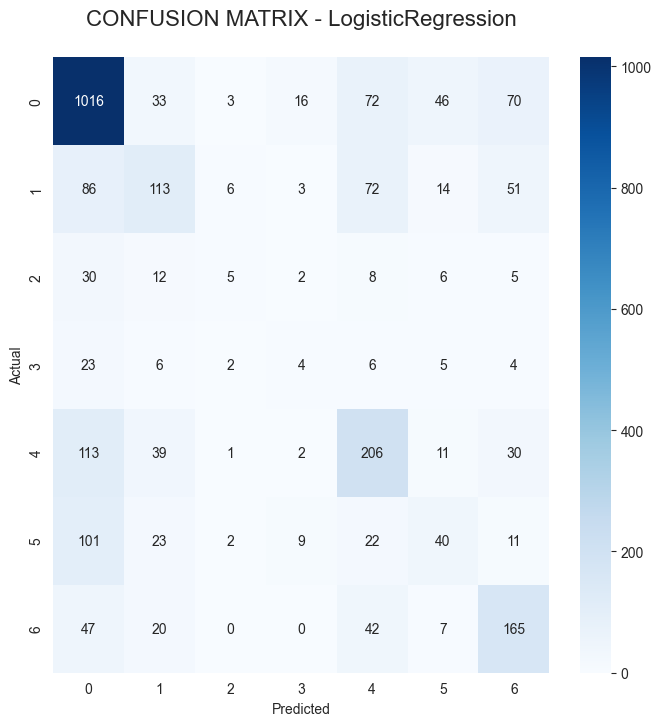

In [37]:
conf_mat = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')#,
            # xticklabels=pd.DataFrame(train1['Emotion'].unique()).values,
            # yticklabels=pd.DataFrame(train1['Emotion'].unique()).values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

In [38]:
y_pred_train = clf.predict(bow_data)

In [39]:
print(metrics.classification_report(labels, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4710
           1       0.96      0.96      0.96      1109
           2       0.95      0.98      0.96       271
           3       0.95      0.99      0.97       268
           4       0.94      0.96      0.95      1743
           5       0.96      0.97      0.96       683
           6       0.91      0.97      0.93      1205

    accuracy                           0.96      9989
   macro avg       0.95      0.97      0.96      9989
weighted avg       0.96      0.96      0.96      9989



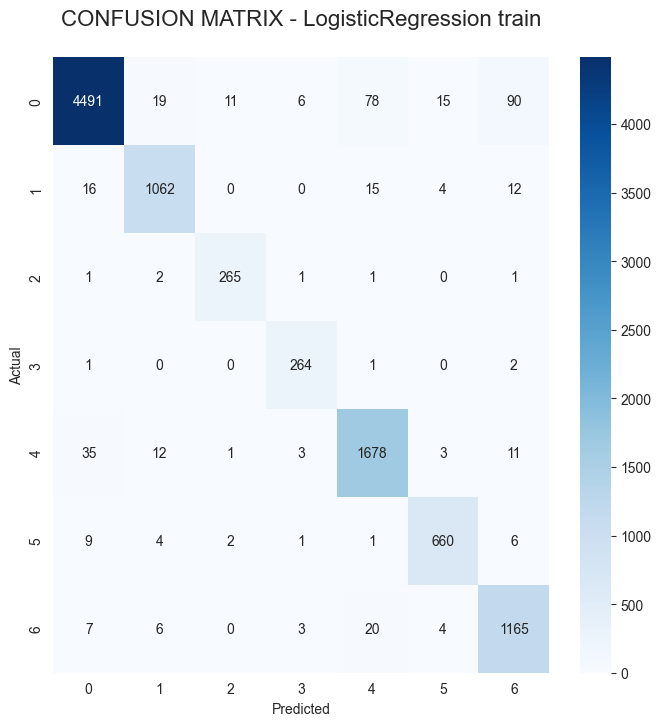

In [40]:
conf_mat = confusion_matrix(labels, y_pred_train)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')#,
            # xticklabels=pd.DataFrame(train1['Emotion'].unique()).values,
            # yticklabels=pd.DataFrame(train1['Emotion'].unique()).values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression train\n", size=16);

### Предсказываем эмоцию по тексту и сантименту (тональные векторы не учитываются)

In [65]:
bow_data

<9989x100538 sparse matrix of type '<class 'numpy.int64'>'
	with 266551 stored elements in Compressed Sparse Row format>

In [18]:
from scipy.sparse import hstack
X_train = bow_data
sent = train['Sentiment'].copy()
X_utt_sen = hstack((bow_data,np.array(sent)[:,None])).A
X_utt_sen

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [20]:
X_utt_sen = scipy.sparse.csr_matrix(X_utt_sen)
X_utt_sen

<9989x100539 sparse matrix of type '<class 'numpy.int64'>'
	with 271830 stored elements in Compressed Sparse Row format>

In [21]:
labels = train.Emotion.copy()

In [22]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    LogisticRegression(random_state=0, max_iter=10000),
    CatBoostClassifier(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_utt_sen, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Learning rate set to 0.087974
0:	learn: 1.6264735	total: 506ms	remaining: 8m 25s
1:	learn: 1.4409303	total: 903ms	remaining: 7m 30s
2:	learn: 1.3085044	total: 1.3s	remaining: 7m 11s
3:	learn: 1.2067819	total: 1.69s	remaining: 7m
4:	learn: 1.1251160	total: 2.09s	remaining: 6m 56s
5:	learn: 1.0544207	total: 2.5s	remaining: 6m 53s
6:	learn: 0.9979696	total: 2.9s	remaining: 6m 51s
7:	learn: 0.9426618	total: 3.31s	remaining: 6m 50s
8:	learn: 0.8932240	total: 3.71s	remaining: 6m 48s
9:	learn: 0.8512093	total: 4.1s	remaining: 6m 46s
10:	learn: 0.8195775	total: 4.52s	remaining: 6m 46s
11:	learn: 0.7903414	total: 4.91s	remaining: 6m 44s
12:	learn: 0.7615793	total: 5.31s	remaining: 6m 42s
13:	learn: 0.7354279	total: 5.7s	remaining: 6m 41s
14:	learn: 0.7130915	total: 6.1s	remaining: 6m 40s
15:	learn: 0.6947546	total: 6.51s	remaining: 6m 40s
16:	learn: 0.6783562	total: 6.92s	remaining: 6m 40s
17:	learn: 0.6622762	total: 7.33s	remaining: 6m 39s
18:	learn: 0.6477014	total: 7.72s	remaining: 6m 38s
19

In [24]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1,
                ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.813095,0.002529
LinearSVC,0.711882,0.009069
LogisticRegression,0.770347,0.003563
RandomForestClassifier,0.471519,0.000106


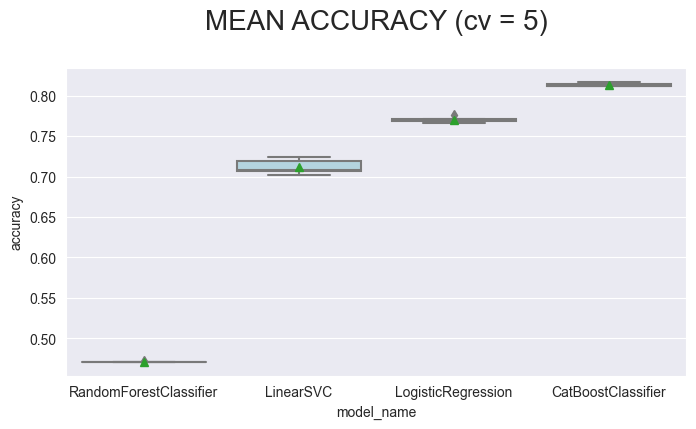

In [25]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

In [34]:
cat = CatBoostClassifier().fit(X_utt_sen, labels)

Learning rate set to 0.088981
0:	learn: 1.6227821	total: 1.24s	remaining: 20m 34s
1:	learn: 1.4360506	total: 1.74s	remaining: 14m 27s
2:	learn: 1.3033326	total: 2.19s	remaining: 12m 7s
3:	learn: 1.1924436	total: 2.62s	remaining: 10m 51s
4:	learn: 1.1107859	total: 3s	remaining: 9m 56s
5:	learn: 1.0435935	total: 3.41s	remaining: 9m 24s
6:	learn: 0.9871939	total: 3.83s	remaining: 9m 2s
7:	learn: 0.9337021	total: 4.26s	remaining: 8m 48s
8:	learn: 0.8906681	total: 4.67s	remaining: 8m 33s
9:	learn: 0.8547823	total: 5.08s	remaining: 8m 23s
10:	learn: 0.8159816	total: 5.49s	remaining: 8m 14s
11:	learn: 0.7883705	total: 5.9s	remaining: 8m 5s
12:	learn: 0.7611297	total: 6.3s	remaining: 7m 58s
13:	learn: 0.7356978	total: 6.71s	remaining: 7m 52s
14:	learn: 0.7128232	total: 7.12s	remaining: 7m 47s
15:	learn: 0.6915868	total: 7.53s	remaining: 7m 43s
16:	learn: 0.6719162	total: 7.94s	remaining: 7m 39s
17:	learn: 0.6555978	total: 8.32s	remaining: 7m 34s
18:	learn: 0.6411576	total: 8.74s	remaining: 7m 

In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test_s, cat()))

In [ ]:
X_utt = hstack((bow_test,np.array(test['Sentiment'])[:,None])).A
X_utt

### Предсказываем сантимент по тексту, затем предсказываем эмоцию по тексту и сантименту

In [36]:
y_test = test.Emotion.copy()

In [40]:
senti_test = sent_clf.predict(bow_test)
X_utt = hstack((bow_test,np.array(senti_test)[:,None])).A
X_utt

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 1,  0,  0, ...,  0,  0, -1],
       [ 0,  0,  0, ...,  0,  0, -1],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [41]:
y_preds = cat.predict(X_utt)

In [42]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_preds))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1256
           1       0.40      0.37      0.39       345
           2       1.00      0.03      0.06        68
           3       0.00      0.00      0.00        50
           4       0.49      0.51      0.50       402
           5       0.34      0.20      0.25       208
           6       0.52      0.42      0.46       281

    accuracy                           0.60      2610
   macro avg       0.49      0.34      0.35      2610
weighted avg       0.57      0.60      0.57      2610



C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

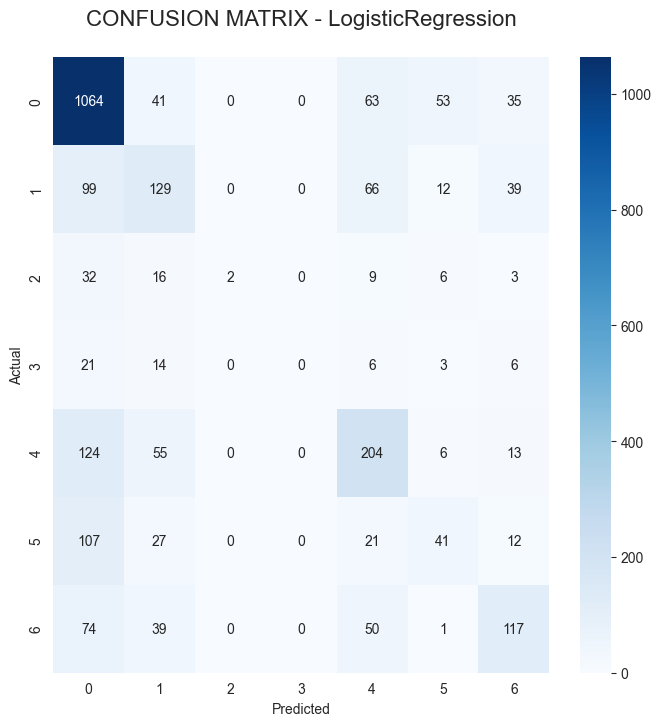

In [44]:
conf_mat = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

In [54]:
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
('svr', LinearSVC(random_state=42, max_iter=10000)),
              ('ct', CatBoostClassifier())]#,
              #('lg', LGBMClassifier())]

In [55]:
from sklearn.ensemble import StackingClassifier
cllff = StackingClassifier(estimators, final_estimator=LogisticRegression(max_iter=10000)).fit(X_utt_sen, labels)

Learning rate set to 0.088981
0:	learn: 1.6227821	total: 476ms	remaining: 7m 55s
1:	learn: 1.4360506	total: 903ms	remaining: 7m 30s
2:	learn: 1.3033326	total: 1.33s	remaining: 7m 20s
3:	learn: 1.1924436	total: 1.74s	remaining: 7m 14s
4:	learn: 1.1107859	total: 2.17s	remaining: 7m 11s
5:	learn: 1.0435935	total: 2.6s	remaining: 7m 10s
6:	learn: 0.9871939	total: 3.03s	remaining: 7m 10s
7:	learn: 0.9337021	total: 3.46s	remaining: 7m 9s
8:	learn: 0.8906681	total: 3.89s	remaining: 7m 8s
9:	learn: 0.8547823	total: 4.31s	remaining: 7m 6s
10:	learn: 0.8159816	total: 4.73s	remaining: 7m 5s
11:	learn: 0.7883705	total: 5.16s	remaining: 7m 5s
12:	learn: 0.7611297	total: 5.61s	remaining: 7m 5s
13:	learn: 0.7356978	total: 6.03s	remaining: 7m 4s
14:	learn: 0.7128232	total: 6.46s	remaining: 7m 4s
15:	learn: 0.6915868	total: 6.89s	remaining: 7m 3s
16:	learn: 0.6719162	total: 7.32s	remaining: 7m 3s
17:	learn: 0.6555978	total: 7.74s	remaining: 7m 2s
18:	learn: 0.6411576	total: 8.17s	remaining: 7m 1s
19:	l

In [56]:
cllff.score(X_utt, y_test)

0.6030651340996168

In [ ]:
y_predss = cllff.predict(X_utt)

In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_predss))

In [ ]:
conf_mat = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);